In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import os
import nltk
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv('amazon_alexa.tsv', sep="\t")

In [3]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
df.tail()

,rating,date,variation,verified_reviews,feedback
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1
3149,4,29-Jul-18,Black Dot,Good,1


In [5]:
df = df.drop(columns=['rating'])

In [6]:
# Check shape of dataset
df.shape

(3150, 4)

In [7]:
df.head()

,date,variation,verified_reviews,feedback
0,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,31-Jul-18,Charcoal Fabric,Loved it!,1
2,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,31-Jul-18,Charcoal Fabric,Music,1


In [8]:
# Check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              3150 non-null   object
 1   variation         3150 non-null   object
 2   verified_reviews  3150 non-null   object
 3   feedback          3150 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 98.6+ KB


Variation Value Counts:
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64

Feedback Value Counts:
1    2893
0     257
Name: feedback, dtype: int64


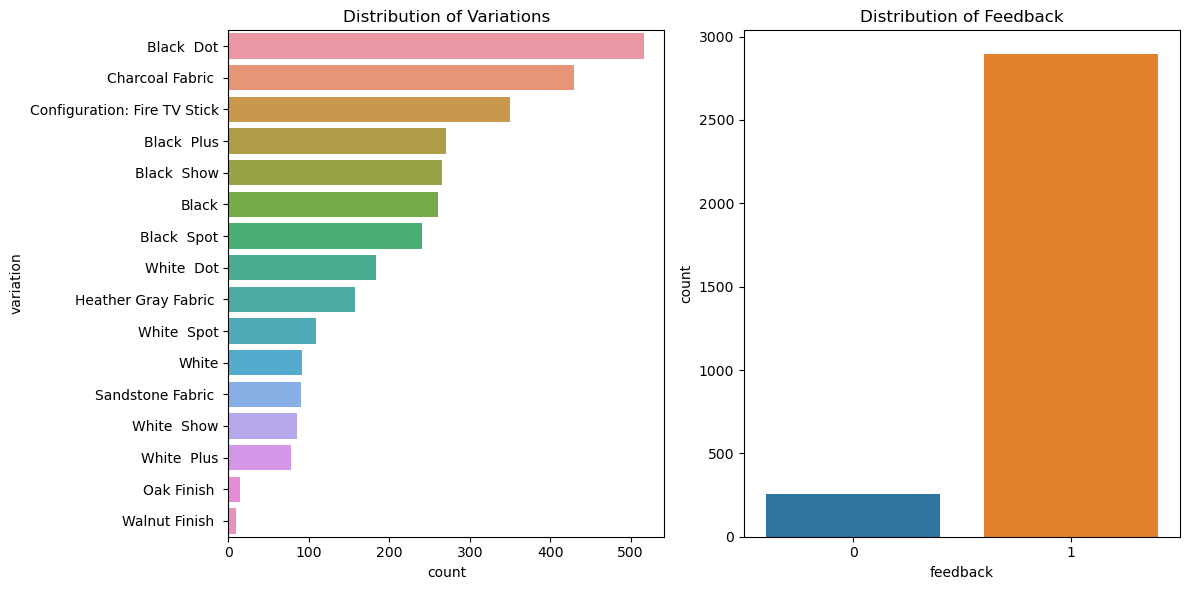

In [9]:
print("Variation Value Counts:")
print(df['variation'].value_counts())

print("\nFeedback Value Counts:")
print(df['feedback'].value_counts())

# Visualization
plt.figure(figsize=(12, 6))

# Plotting the distribution of the 'variation' column
plt.subplot(1, 2, 1)
sns.countplot(y='variation', data=df, order = df['variation'].value_counts().index)
plt.title('Distribution of Variations')

# Plotting the distribution of the 'feedback' column
plt.subplot(1, 2, 2)
sns.countplot(x='feedback', data=df)
plt.title('Distribution of Feedback')

plt.tight_layout()
plt.show()

In [10]:
print("\nFeedback Value Counts:")
print(df['feedback'].value_counts())


Feedback Value Counts:
1    2893
0     257
Name: feedback, dtype: int64


In [11]:
# check for null values
df.isnull().sum()

date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [12]:
df

,date,variation,verified_reviews,feedback
0,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,31-Jul-18,Charcoal Fabric,Loved it!,1
2,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...
3145,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


In [13]:
df.head()

,date,variation,verified_reviews,feedback
0,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,31-Jul-18,Charcoal Fabric,Loved it!,1
2,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,31-Jul-18,Charcoal Fabric,Music,1


In [14]:
# Initialize stop words
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    # Remove special characters and convert to lowercase
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

df['verified_reviews'] = df['verified_reviews'].apply(preprocess_text)

In [15]:
# Remove unwanted characters or symbols
df['verified_reviews'] = df['verified_reviews'].str.replace('[^a-zA-Z]', ' ', regex=True)

In [16]:
df.head()

,date,variation,verified_reviews,feedback
0,31-Jul-18,Charcoal Fabric,love echo,1
1,31-Jul-18,Charcoal Fabric,loved,1
2,31-Jul-18,Walnut Finish,sometimes playing game answer question correct...,1
3,31-Jul-18,Charcoal Fabric,lot fun thing yr old learns dinosaurs contro...,1
4,31-Jul-18,Charcoal Fabric,music,1


In [17]:
df1 = df.copy()

In [18]:
df1.head()

,date,variation,verified_reviews,feedback
0,31-Jul-18,Charcoal Fabric,love echo,1
1,31-Jul-18,Charcoal Fabric,loved,1
2,31-Jul-18,Walnut Finish,sometimes playing game answer question correct...,1
3,31-Jul-18,Charcoal Fabric,lot fun thing yr old learns dinosaurs contro...,1
4,31-Jul-18,Charcoal Fabric,music,1


In [19]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to convert NLTK tag to a WordNet tag
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Function to lemmatize text
def lemmatize_text(text):
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words]
    return ' '.join(lemmatized_words)

# Applying the lemmatization function to each row in the review column
df1['lemmatized_review'] = df1['verified_reviews'].apply(lemmatize_text)



In [20]:
df1.tail()

,date,variation,verified_reviews,feedback,lemmatized_review
3145,30-Jul-18,Black Dot,perfect kids adults everyone,1,perfect kid adult everyone
3146,30-Jul-18,Black Dot,listening music searching locations checking t...,1,listen music search location check time look w...
3147,30-Jul-18,Black Dot,love things running entire home tv lights ther...,1,love thing run entire home tv light thermostat...
3148,30-Jul-18,White Dot,complaint sound quality great mostly use comma...,1,complaint sound quality great mostly use comma...
3149,29-Jul-18,Black Dot,good,1,good


In [21]:
df1['feedback'].value_counts()

1    2893
0     257
Name: feedback, dtype: int64

In [22]:
# Initialize the CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the feedback column into word matrix
count_matrix = count_vectorizer.fit_transform(df1['lemmatized_review'])

In [23]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the 'Comment' column into a TF-IDF matrix
X = vectorizer.fit_transform(df1['lemmatized_review'])
y = df1['feedback']

In [24]:
# Extract unique words from 'Comment'
count_vocab = count_vectorizer.get_feature_names_out()
tfidf_vocab = vectorizer.get_feature_names_out()

In [25]:
# Create dictionary to map words to frequencies
count_word_freq = count_matrix.sum(axis=0)
word_freq_dict = dict(zip(count_vocab, count_word_freq.A1))

In [26]:
# Get word list and average TF-IDF scores
tfidf_word_scores = zip(tfidf_vocab, count_matrix.toarray().mean(axis=0))
tfidf_word_scores = sorted(tfidf_word_scores, key=lambda x: x[1], reverse=True)

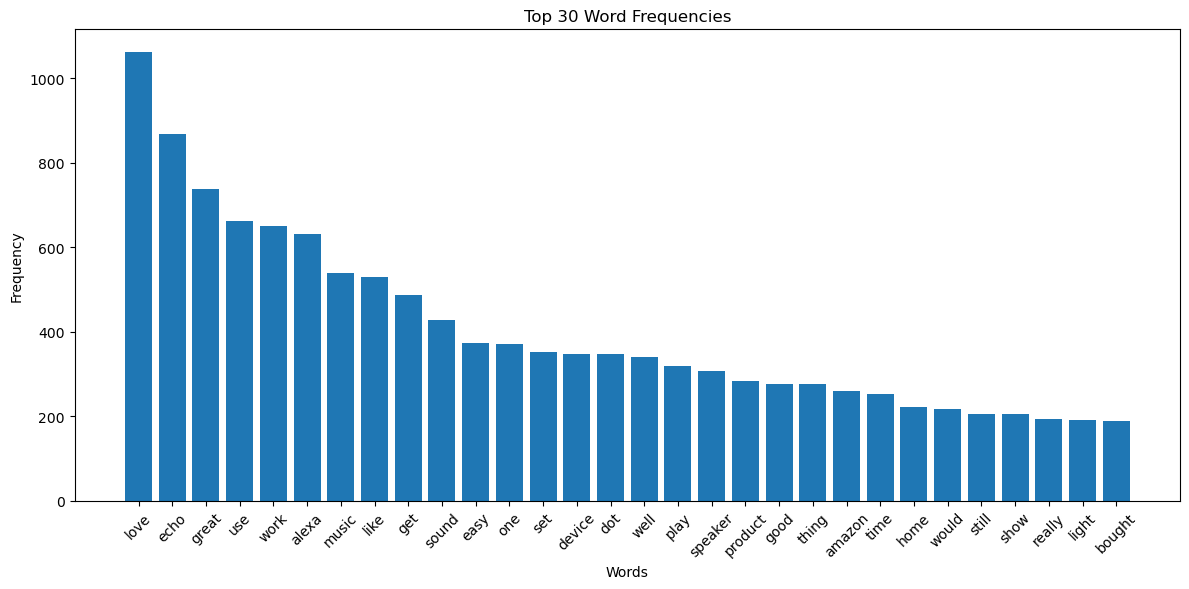

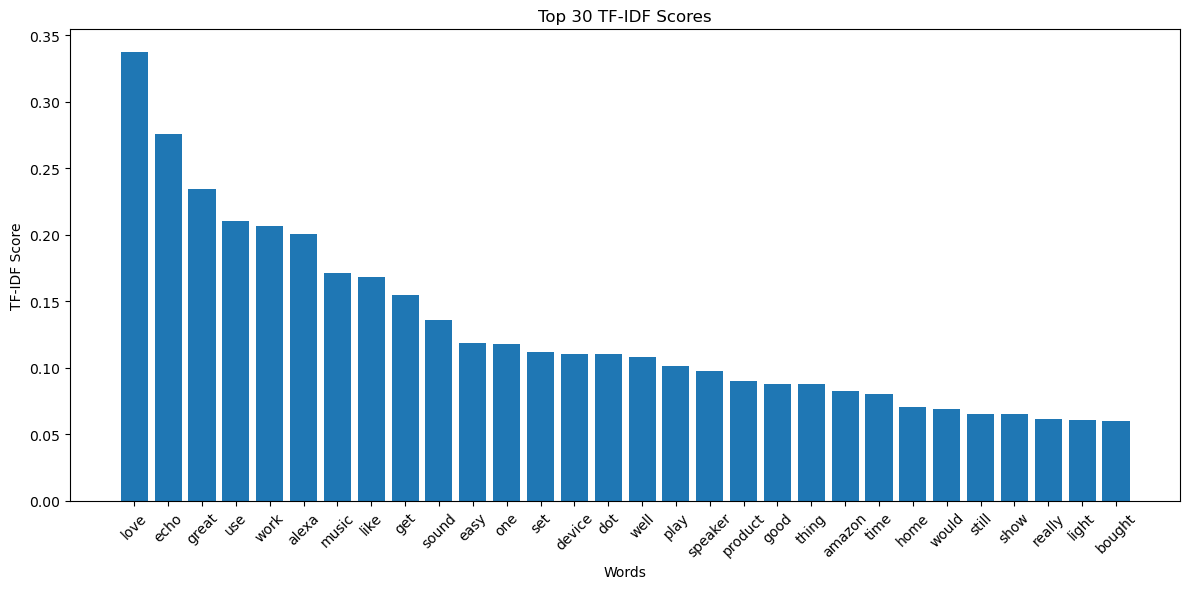

In [27]:
# Plotting word frequencies
top_words = 30
top_words_freq = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)[:top_words]
words, frequencies = zip(*top_words_freq)
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Word Frequencies'.format(top_words))
plt.tight_layout()
plt.show()

# TF-IDF scores
top_words_tfidf = tfidf_word_scores[:top_words]
words, tfidf_scores = zip(*top_words_tfidf)
plt.figure(figsize=(12, 6))
plt.bar(words, tfidf_scores)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.title('Top {} TF-IDF Scores'.format(top_words))
plt.tight_layout()
plt.show()

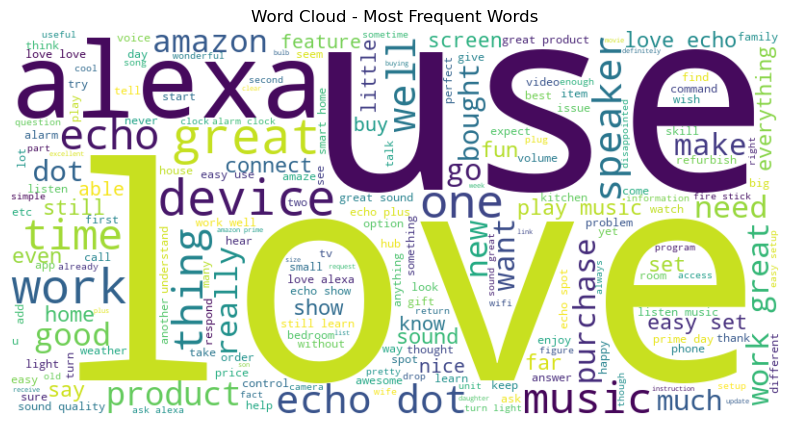

In [28]:
text_data = ' '.join(df1['lemmatized_review'].astype(str))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot the Word Cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Most Frequent Words')
plt.show()

In [29]:
# Sentiment Analysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Check if class labels are balanced
y_train.value_counts()

1    2321
0     199
Name: feedback, dtype: int64

<Axes: xlabel='feedback', ylabel='count'>

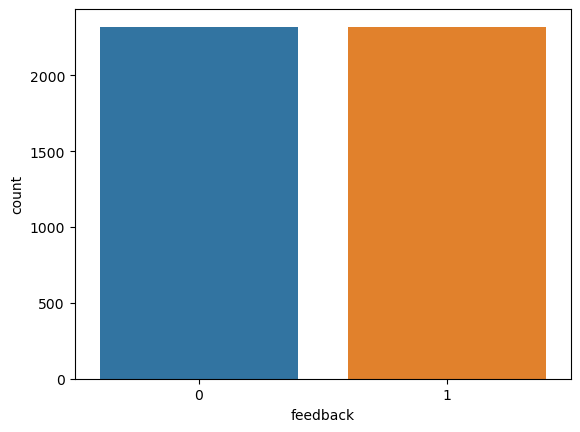

In [31]:
from imblearn.over_sampling import SMOTE

resampler = SMOTE(random_state=0)
X_train, y_train = resampler.fit_resample(X_train,y_train)

sns.countplot(x= y_train)

In [32]:
y_train.value_counts()

1    2321
0    2321
Name: feedback, dtype: int64

In [33]:
# Train Random Forest classifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [34]:
# Predict lables for test set
y_pred = classifier.predict(X_test)

In [35]:
y_pred

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,

In [36]:
# Model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1-score:", f1)
print("Recall:", recall)
print('Classification_report:')
print(classification_report)

Accuracy: 0.9142857142857143
Precision: 0.9625
F1-score: 0.9522968197879859
Recall: 0.9423076923076923
Classification_report:
              precision    recall  f1-score   support

           0       0.53      0.64      0.58        58
           1       0.96      0.94      0.95       572

    accuracy                           0.91       630
   macro avg       0.75      0.79      0.77       630
weighted avg       0.92      0.91      0.92       630



In [37]:
# Visualize the data using wordcloud
reviews_words = ' '.join(df1[df1['feedback'] == 1]['lemmatized_review'])
not_reviews_words = ' '.join(df1[df1['feedback'] == 0]['lemmatized_review'])
reviews_word_cloud = WordCloud(width=800, height=400).generate(reviews_words)
not_reviews_wordcloud = WordCloud(width=800, height=400).generate(not_reviews_words)

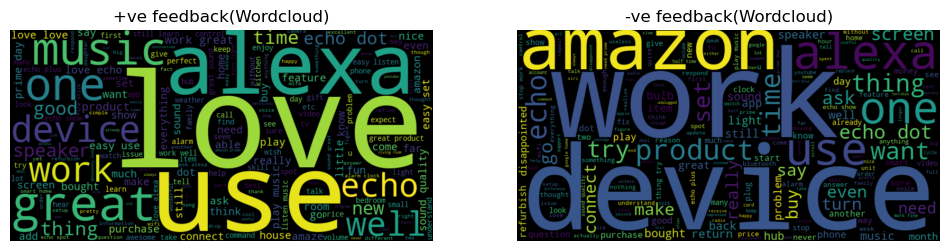

In [38]:
plt.figure(figsize=(12, 12))

# First subplot for reviews_words cloud
plt.subplot(1, 2, 1)
plt.imshow(reviews_word_cloud, interpolation='bilinear')
plt.title('+ve feedback(Wordcloud)')
plt.axis('off')

# Second subplot for the not_reviews_words cloud
plt.subplot(1, 2, 2)
plt.imshow(not_reviews_wordcloud, interpolation='bilinear')
plt.title('-ve feedback(Wordcloud)')
plt.axis('off')

plt.show()

In [39]:
# Perform sentiment analysis on each text sample
sentiments = []
for text in df1['lemmatized_review']:
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    sentiments.append(sentiment)

In [40]:
# Add sentiment scores
df1['Sentiment'] = sentiments

In [41]:
df1.head()

,date,variation,verified_reviews,feedback,lemmatized_review,Sentiment
0,31-Jul-18,Charcoal Fabric,love echo,1,love echo,0.500000
1,31-Jul-18,Charcoal Fabric,loved,1,love,0.500000
2,31-Jul-18,Walnut Finish,sometimes playing game answer question correct...,1,sometimes play game answer question correctly ...,0.000000
3,31-Jul-18,Charcoal Fabric,lot fun thing yr old learns dinosaurs contro...,1,lot fun thing yr old learns dinosaur control l...,0.233333
4,31-Jul-18,Charcoal Fabric,music,1,music,0.000000


In [42]:
# Classify the sentiments based on a threshold (positive if sentiment > 0.5, negative if sentiment < -0.5, neutral otherwise)
df1['Sentiment_Label'] = df1['Sentiment'].apply(lambda x: 'positive' if x > 0.5 else 'negative' if x < -0.5 else 'neutral')

In [43]:
df1.head()

,date,variation,verified_reviews,feedback,lemmatized_review,Sentiment,Sentiment_Label
0,31-Jul-18,Charcoal Fabric,love echo,1,love echo,0.500000,neutral
1,31-Jul-18,Charcoal Fabric,loved,1,love,0.500000,neutral
2,31-Jul-18,Walnut Finish,sometimes playing game answer question correct...,1,sometimes play game answer question correctly ...,0.000000,neutral
3,31-Jul-18,Charcoal Fabric,lot fun thing yr old learns dinosaurs contro...,1,lot fun thing yr old learns dinosaur control l...,0.233333,neutral
4,31-Jul-18,Charcoal Fabric,music,1,music,0.000000,neutral


In [44]:
df1.tail()

,date,variation,verified_reviews,feedback,lemmatized_review,Sentiment,Sentiment_Label
3145,30-Jul-18,Black Dot,perfect kids adults everyone,1,perfect kid adult everyone,0.550000,positive
3146,30-Jul-18,Black Dot,listening music searching locations checking t...,1,listen music search location check time look w...,0.250000,neutral
3147,30-Jul-18,Black Dot,love things running entire home tv lights ther...,1,love thing run entire home tv light thermostat...,0.219481,neutral
3148,30-Jul-18,White Dot,complaint sound quality great mostly use comma...,1,complaint sound quality great mostly use comma...,0.383036,neutral
3149,29-Jul-18,Black Dot,good,1,good,0.700000,positive


In [45]:
# Print the sentiment labels
print(df1[['lemmatized_review', 'Sentiment_Label']])

                                      lemmatized_review Sentiment_Label
0                                             love echo         neutral
1                                                  love         neutral
2     sometimes play game answer question correctly ...         neutral
3     lot fun thing yr old learns dinosaur control l...         neutral
4                                                 music         neutral
...                                                 ...             ...
3145                         perfect kid adult everyone        positive
3146  listen music search location check time look w...         neutral
3147  love thing run entire home tv light thermostat...         neutral
3148  complaint sound quality great mostly use comma...         neutral
3149                                               good        positive

[3150 rows x 2 columns]


In [46]:
# Convert text data to document-term matrix
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(df1['lemmatized_review'])
# Apply LDA to extract topics
lda_model = LatentDirichletAllocation(n_components=3) 
lda_model.fit(dtm)
# Get the most probable words for each review
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(f"Review {topic_idx+1}: ", top_words)

Review 1:  ['echo', 'work', 'sound', 'great', 'dot', 'like', 'love', 'speaker', 'music', 'one']
Review 2:  ['alexa', 'love', 'music', 'get', 'great', 'light', 'time', 'thing', 'echo', 'play']
Review 3:  ['love', 'use', 'easy', 'set', 'alexa', 'work', 'great', 'like', 'device', 'amazon']
